### Парсинг из папки с текстовыми файлами в таблицу

In [1]:
!python parse_data.py data data.csv

[+]	./data/Bergman/Autumn Sonata.srt                  	PARSED
[+]	./data/Bergman/Cries and whispers.srt             	PARSED
[+]	./data/Bergman/Fanny and Alexander.srt            	PARSED
[+]	./data/Bergman/Persona.srt                        	PARSED
[+]	./data/Bergman/Scenes from a Marriage.srt         	PARSED
[+]	./data/Bergman/The Seventh Seal.srt               	PARSED
[+]	./data/Bergman/Wild Strawberries.srt              	PARSED
[+]	./data/Bergman/Winter Light.srt                   	PARSED
[+]	./data/Tarkovsky/Andrei Rublyov.txt               	PARSED
[+]	./data/Tarkovsky/Ivan's Childhood.txt             	PARSED
[+]	./data/Tarkovsky/Nostalgia.txt                    	PARSED
[+]	./data/Tarkovsky/Sacrifice.txt                    	PARSED
[+]	./data/Tarkovsky/Solaris.txt                      	PARSED
[+]	./data/Tarkovsky/Stalker.txt                      	PARSED
[+]	./data/Tarkovsky/The Mirror.srt                   	PARSED
[+]	./data/Von Trier/Antichrist.srt                   	PARSED
[+]	./da

### Импорт библиотек

In [2]:
import re
import string
from typing import List

import matplotlib.pyplot as plt
import nltk
import nltk.data
import pandas as pd
import seaborn as sns
import spacy
from bertopic import BERTopic
from lemmatization_utils import lemmatize_sentence
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from textblob.taggers import NLTKTagger
from wordcloud import ImageColorGenerator, WordCloud

%matplotlib inline
sns.set_theme(style="ticks", palette="pastel")

# Install nltk submodules
# Install spacy submodules
nltk_modules = ["punkt", "stopwords", "wordnet", "omw-1.4"]
if False:
    for module in nltk_modules:
        nltk.download(module)
    !python -m spacy download en_core_web_sm

### Загрузка данных

In [3]:
raw_df = pd.read_csv('./data/data.csv')
raw_df.head()

author                    name  \
0  Bergman           Autumn Sonata   
1  Bergman      Cries and whispers   
2  Bergman     Fanny and Alexander   
3  Bergman                 Persona   
4  Bergman  Scenes from a Marriage   

                                                text  
0  sometimes i stand looking at my wife without h...  
1  it is early monday morning... and i am in pain...  
2  fanny. mother. siri. maj. grandma. alexander. ...  
3  you wished to speak to me, doctor? have you se...  
4  - this room will be ideal for pictures. - sit ...

# 1. Exploratory Data Analysis

### 1.1. Средняя длина предложения в корпусе по автору

Сгруппируем данные по автору для того, чтобы оценить среднюю длину предложения для каждого из авторов:

In [5]:
sentences_df = pd.DataFrame(raw_df.groupby(['author'])['text'].sum()).reset_index()
sentences_df

author                                               text
0    Bergman  sometimes i stand looking at my wife without h...
1  Tarkovsky  Pull the rope. - This one? - Arkhip, give me t...
2  Von Trier  how are you? didn't we just talk about that? t...

Разобьём наборы субтитров для каждого автора на отдельные предложения:

In [6]:
# Токенизатор по предложениям
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Приводим текст к списку предложений
sentences_df['sentences'] = sentences_df['text'].apply(lambda row: tokenizer.tokenize(row))

# Считаем длины предложений
sentences_df['sentences_len'] = sentences_df['sentences'].apply(
    lambda sentences: [len(sentence.split()) for sentence in sentences]
)

sentences_df

author                                               text  \
0    Bergman  sometimes i stand looking at my wife without h...   
1  Tarkovsky  Pull the rope. - This one? - Arkhip, give me t...   
2  Von Trier  how are you? didn't we just talk about that? t...   

                                           sentences  \
0  [sometimes i stand looking at my wife without ...   
1  [Pull the rope., - This one?, - Arkhip, give m...   
2  [how are you?, didn't we just talk about that?...   

                                       sentences_len  
0  [12, 12, 5, 6, 8, 6, 8, 11, 9, 14, 5, 11, 10, ...  
1  [3, 3, 6, 3, 2, 1, 5, 5, 4, 5, 4, 3, 4, 2, 3, ...  
2  [3, 6, 3, 3, 5, 2, 13, 13, 8, 27, 13, 12, 3, 4...

Оценим ящики с усами для каждого набора данных:

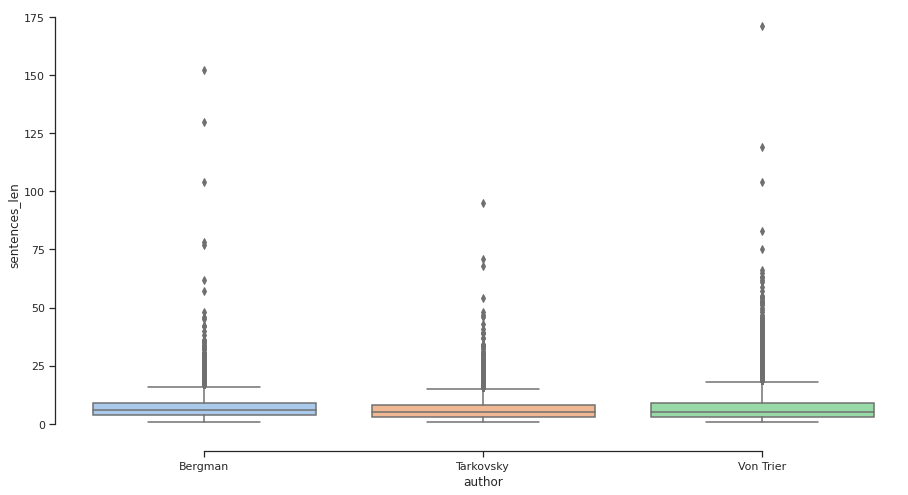

In [7]:
# Собираем данные, для этого раскладываем для каждого автора длины предложений
data = sentences_df[['author', 'sentences_len']].explode('sentences_len')
data['sentences_len'] = data['sentences_len'].astype(int)

# Рисуем график
plt.figure(figsize=(15, 8))
sns.boxplot(x='author', y='sentences_len',
            data=data)
sns.despine(offset=10, trim=True)
plt.show()

Очевидно, имеются выбросы. Вероятно, при разбиении часть субтитров была представлена сплошным текстом, из-за этого при разбиении по пунктуации вся эта часть стала одним предложением. Возможно, стоит дополнительно оценить число предложений после разбиения для каждого из авторов:

In [8]:
data['author'].value_counts()

Von Trier    12199
Bergman       8590
Tarkovsky     7008
Name: author, dtype: int64

Похоже, наша гипотеза подтверждается. Взглянем на топ-50 по выбросам и удалим выбросы из корпуса:

In [9]:
tarkovsky_repl = """And now summer has left
as if it never came at all.
It’s warm still where the sun falls.
But it’s not enough.

Whatever I wanted to happen
fell right into my hands
like a five-fingered leaf.
But it’s not enough.

The just and unjust
played their necessary part
and burned into light.
But it’s not enough.

Life tucked me behind its back
and shielded me from cuffs.
I’ve had such good luck.
But it’s not enough.

My leaves have yet to blaze;
my branches have not yet broken.
The day is clear as glass —
but it’s not enough."""


all_sentences = [item for sublist in list(sentences_df['sentences']) for item in sublist]
for sentence in sorted(all_sentences, key=len)[:-50:-1]:
    pattern = ' '.join(sentence.split()[:4])
    result = raw_df['text'].str.contains(pattern, regex=False)
    
    try:
        idx = result[result == True].index[0]
        name = list(raw_df[raw_df.index == idx]['name'].values)[0]
    except IndexError:
        pass
    
    print(name)
    print(sentence + '\n')
    print(raw_df[raw_df.index == idx])
    print('\n\n\n')

    # Удаляем выбросы (песни и стихи)
    if (sentence.find(r'v(tm)ie') != -1 or 
        name == 'Fanny and Alexander' or
        sentence.startswith('hit the road jack') or
        name == 'The Seventh Seal' or
        sentence.startswith('I love those eyes of yours, my friend') or
        sentence.startswith('mirror margarita terekhova as mother')
       ):
        start = sentence.split()[:4]
        end = sentence.split()[-4:]
        start = ''.join(['\\' + sym if sym in string.punctuation else sym for sym in ' '.join(start)])
        end = ''.join(['\\' + sym if sym in string.punctuation else sym for sym in ' '.join(end)])
        
        reg_expr = start + '.+' + end
        reg_expr_compiled = re.compile(reg_expr)
        
        raw_df['text'] = raw_df['text'].apply(
            lambda text: re.sub(reg_expr_compiled, '', text)
        )
        
    # Заменяем стих у Тарковского
    if sentence.find('Now the summer is passed') != -1:
        start = sentence.split()[:4]
        end = sentence.split()[-4:]
        start = ''.join(['\\' + sym if sym in string.punctuation else sym for sym in ' '.join(start)])
        end = ''.join(['\\' + sym if sym in string.punctuation else sym for sym in ' '.join(end)])
        
        reg_expr = start + '.+' + end
        reg_expr_compiled = re.compile(reg_expr)
        
        raw_df['text'] = raw_df['text'].apply(
            lambda text: re.sub(reg_expr_compiled, tarkovsky_repl, text)
        )

Breaking the Waves
v(tm)ie it's a god-awful small affair v(tm)ie v(tm)ie to the girl with the mousy hair v(tm)ie v(tm)ie but her mummy is yelling no v(tm)ie v(tm)ie and her daddy has told her to go v(tm)ie v(tm)ie but her friend is nowhere to be seen v(tm)ie v(tm)ie now she walks through her sunken dream v(tm)ie v(tm)ie to the seat with the clearest view v(tm)ie v(tm)ie and she's hooked to the silver screen v(tm)ie v(tm)ie but the film is a saddening bore v(tm)ie v(tm)ie 'cause she's lived it ten times or more v(tm)ie v(tm)ie she could spit in the eyes of fools v(tm)ie v(tm)ie as they ask her to focus on v(tm)ie v(tm)ie sailors v(tm)ie v(tm)ie fighting in the dance hall v(tm)ie v(tm)ie oh, man, look at those cavemen go v(tm)ie v(tm)ie it's the freakiest show v(tm)ie v(tm)ie take a look at the lawman v(tm)ie v(tm)ie beating up the wrong guy v(tm)ie v(tm)ie oh, man, wonder if he'll ever know v(tm)ie v(tm)ie he's in the best-selling show v(tm)ie v(tm)ie is there life on mars?

       auth

Оценим ящик с усами после очистки:

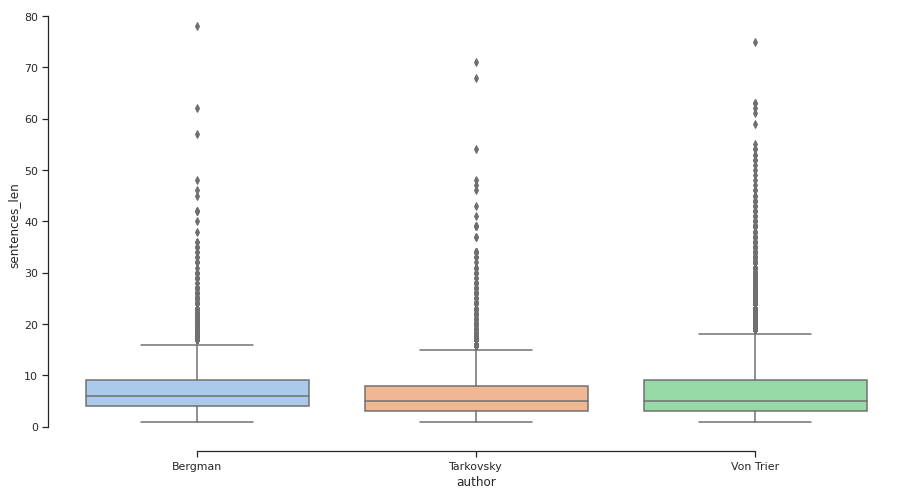

In [10]:
sentences_df = pd.DataFrame(raw_df.groupby(['author'])['text'].sum()).reset_index()
sentences_df

# Токенизатор по предложениям
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Приводим текст к списку предложений
sentences_df['sentences'] = sentences_df['text'].apply(lambda row: tokenizer.tokenize(row))

# Считаем длины предложений
sentences_df['sentences_len'] = sentences_df['sentences'].apply(
    lambda sentences: [len(sentence.split()) for sentence in sentences]
)

# Собираем данные, для этого раскладываем для каждого автора длины предложений
data = sentences_df[['author', 'sentences_len']].explode('sentences_len')
data['sentences_len'] = data['sentences_len'].astype(int)

# Рисуем график
plt.figure(figsize=(15, 8))
sns.boxplot(x='author', y='sentences_len',
            data=data)
sns.despine(offset=10, trim=True)
plt.show()

И оставшиеся выбросы:

In [11]:
all_sentences = [item for sublist in list(sentences_df['sentences']) for item in sublist]
for sentence in sorted(all_sentences, key=len)[:-50:-1]:
    pattern = ' '.join(sentence.split()[:4])
    result = raw_df['text'].str.contains(pattern, regex=False)

    idx = result[result == True].index[0]
    name = list(raw_df[raw_df.index == idx]['name'].values)[0]
        
    print(name)
    print(sentence + '\n')
    print(raw_df[raw_df.index == idx])
    print('\n\n\n')

Stalker
I love those eyes of yours, my friend, Their sparkling, flashing, fiery wonder; When suddenly those lids ascend, Then lightning rips the sky asunder; You swiftly glance, and there's an end; There's greater charm, though, to admire When lowered are those eyes divine In moments kissed by passion's fire; When through the downcast lashes shine The smoldering embers of desire...mosfilm fourth artists' association what is your first name, your last name?

       author     name                                               text
13  Tarkovsky  Stalker  "Was it a meteorite or a visitation from outer...




Dogville
she had known that if she were not shot when the gangsters arrived "she would be faced with her father's suggestion that she return, to become" a conspirator with him and his gang of thugs and felons and she did not need any walk "to reconsider her response to that," even though the difference betwen the people she knew back home and the people she'd met in dogville had prov

Дополнительно оценим число выбросов по [интерквартильному размаху](https://congyuzhou.medium.com/%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9-%D1%80%D0%B0%D0%B7%D0%BC%D0%B0%D1%85-28604de365a0):

In [12]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries


sentence_len_boudaries = calculate_outliers(data['sentences_len'])
print('Границы для нормальных значений:', sentence_len_boudaries)

Границы для нормальных значений: (-4.5, 15.5)


In [13]:
is_outlier = ((data['sentences_len'] < sentence_len_boudaries[0]) | 
              (data['sentences_len'] > sentence_len_boudaries[1]))
print(f'Количество выбросов: {is_outlier.sum()}')
print(f'Доля выбросов: {round(is_outlier.sum() / len(data) * 100, 2)}%')

Количество выбросов: 1813
Доля выбросов: 6.52%


### 1.2. Средняя длина предложения во всем корпусе

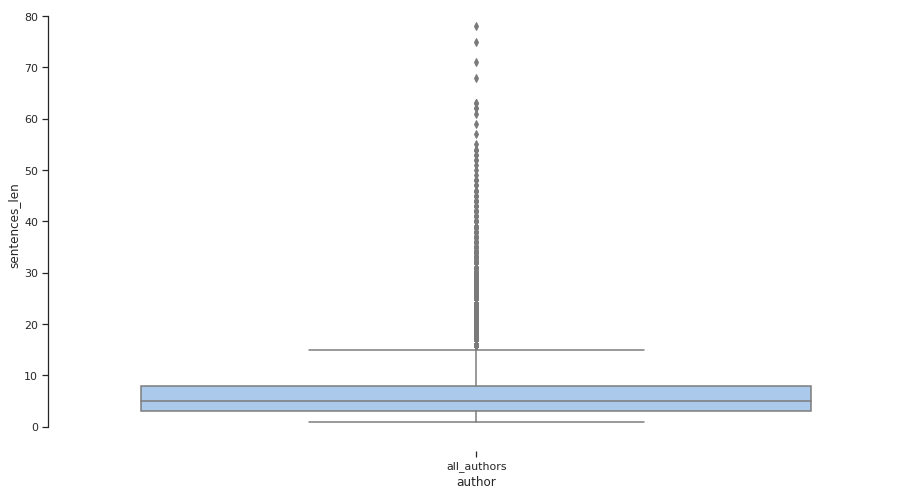

In [14]:
data_all = data.copy()
data_all['author'] = 'all_authors'

plt.figure(figsize=(15, 8))
sns.boxplot(x='author', y='sentences_len',
            data=data_all)
sns.despine(offset=10, trim=True)
plt.show()

### 1.3. Самые частые N-граммы по автору

In [15]:
def sentences_normalization(sentences: List[str]) -> List[str]:
    # Приведение к нижнему регистру
    lowered = [sentence.lower() for sentence in sentences]
    
    # Очистка от пунктуации
    punct_cleaned = [''.join([sym for sym in sentence if sym not in string.punctuation]) for sentence in lowered]
    
    # Лемматизация с применением POS-тэггинга
    lemmatized = [' '.join(lemmatize_sentence(sentence)) for sentence in punct_cleaned]
    
    # Токенизация
    tokenized = [nltk.word_tokenize(sentence) for sentence in punct_cleaned]
    
    # Очистка от стоп-слов
    without_stopwords = [
        [word for word in tokenized_sentence 
         if word not in stopwords.words('english') + ['ill', 'im', 'shell', 'hell', 'shes', 
                                                      'hes', 'well', 'vtmie', 'ye', 'dont',
                                                      'didnt', 'vdj', 'youll', 'whats', 'theyre', 
                                                      'wheres', 'cant', 'youd', 'wouldnt', 'gonna', 
                                                      'id', 'thats', 'couldnt', 'isnt', 'wont', 
                                                      'theres', 'doesnt', 'wasnt', 'arent', 
                                                      'havent', 'youve', 'youre', 'gon', 'na', 
                                                      'ive', 'ticktock', 'yeah', 'whoo', 'okay', 'shouldnt',
                                                      'ravn', 'kay', 'john', 'terry']]
        for tokenized_sentence in tokenized
    ]
    
    # Сбор нормализованных предложений в строки из токенов
    norm_sentences = [' '.join(tokens) for tokens in without_stopwords if tokens]
    return norm_sentences


sentences_df['sentences_norm'] = sentences_df['sentences'].apply(
    lambda sentences: sentences_normalization(sentences))
sentences_df['tokens'] = sentences_df['sentences_norm'].apply(
    lambda sentences: nltk.word_tokenize(' '.join(sentences)))

sentences_df

author                                               text  \
0    Bergman  sometimes i stand looking at my wife without h...   
1  Tarkovsky  Pull the rope. - This one? - Arkhip, give me t...   
2  Von Trier  how are you? didn't we just talk about that? t...   

                                           sentences  \
0  [sometimes i stand looking at my wife without ...   
1  [Pull the rope., - This one?, - Arkhip, give m...   
2  [how are you?, didn't we just talk about that?...   

                                       sentences_len  \
0  [12, 12, 5, 6, 8, 6, 8, 11, 9, 14, 5, 11, 10, ...   
1  [3, 3, 6, 3, 2, 1, 5, 5, 4, 5, 4, 3, 4, 2, 3, ...   
2  [3, 6, 3, 3, 5, 2, 13, 13, 8, 27, 13, 12, 3, 4...   

                                      sentences_norm  \
0  [sometimes stand looking wife without knowing,...   
1  [pull rope, one, arkhip give strap, hold, take...   
2  [talk, yesterday, today tuesday, long, month, ...   

                                              tokens  
0  [sometimes, stand, looking, wife, without, kno...  
1  [pull, rope, one, arkhip, give, strap, hold, t...  
2  [talk, yesterday, today, tuesday, long, month,...

In [16]:
def generate_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


sentences_df['bigrams'] = sentences_df['tokens'].apply(lambda tokens: generate_ngrams(tokens, 2))
sentences_df['trigrams'] = sentences_df['tokens'].apply(lambda tokens: generate_ngrams(tokens, 3))
sentences_df

author                                               text  \
0    Bergman  sometimes i stand looking at my wife without h...   
1  Tarkovsky  Pull the rope. - This one? - Arkhip, give me t...   
2  Von Trier  how are you? didn't we just talk about that? t...   

                                           sentences  \
0  [sometimes i stand looking at my wife without ...   
1  [Pull the rope., - This one?, - Arkhip, give m...   
2  [how are you?, didn't we just talk about that?...   

                                       sentences_len  \
0  [12, 12, 5, 6, 8, 6, 8, 11, 9, 14, 5, 11, 10, ...   
1  [3, 3, 6, 3, 2, 1, 5, 5, 4, 5, 4, 3, 4, 2, 3, ...   
2  [3, 6, 3, 3, 5, 2, 13, 13, 8, 27, 13, 12, 3, 4...   

                                      sentences_norm  \
0  [sometimes stand looking wife without knowing,...   
1  [pull rope, one, arkhip give strap, hold, take...   
2  [talk, yesterday, today tuesday, long, month, ...   

                                              tokens  \
0  [sometimes, stand, looking, wife, without, kno...   
1  [pull, rope, one, arkhip, give, strap, hold, t...   
2  [talk, yesterday, today, tuesday, long, month,...   

                                             bigrams  \
0  [sometimes stand, stand looking, looking wife,...   
1  [pull rope, rope one, one arkhip, arkhip give,...   
2  [talk yesterday, yesterday today, today tuesda...   

                                            trigrams  
0  [sometimes stand looking, stand looking wife, ...  
1  [pull rope one, rope one arkhip, one arkhip gi...  
2  [talk yesterday today, yesterday today tuesday...

In [17]:
bigrams_data = sentences_df[['author', 'bigrams']].explode('bigrams')
trigrams_data = sentences_df[['author', 'trigrams']].explode('trigrams')

bigrams_top_10 = pd.DataFrame(bigrams_data.value_counts()[:10]).reset_index()
trigrams_top_10 = pd.DataFrame(trigrams_data.value_counts()[:10]).reset_index()

bigrams_top_10.columns = ['author', 'bigrams', 'count']
trigrams_top_10.columns = ['author', 'trigrams', 'count']

bigrams_top_10 = bigrams_top_10.sort_values(by='count', ascending=False)
trigrams_top_10 = trigrams_top_10.sort_values(by='count', ascending=False)

Оценим у какого автора самые частотные N-граммы:

In [18]:
pd.DataFrame(bigrams_top_10.groupby('author')['count'].sum())

count
author          
Bergman       73
Tarkovsky     38
Von Trier    105

In [19]:
pd.DataFrame(trigrams_top_10.groupby('author')['count'].sum())

count
author          
Bergman       10
Von Trier     45

Построим распределения топа-10 N-грамм:

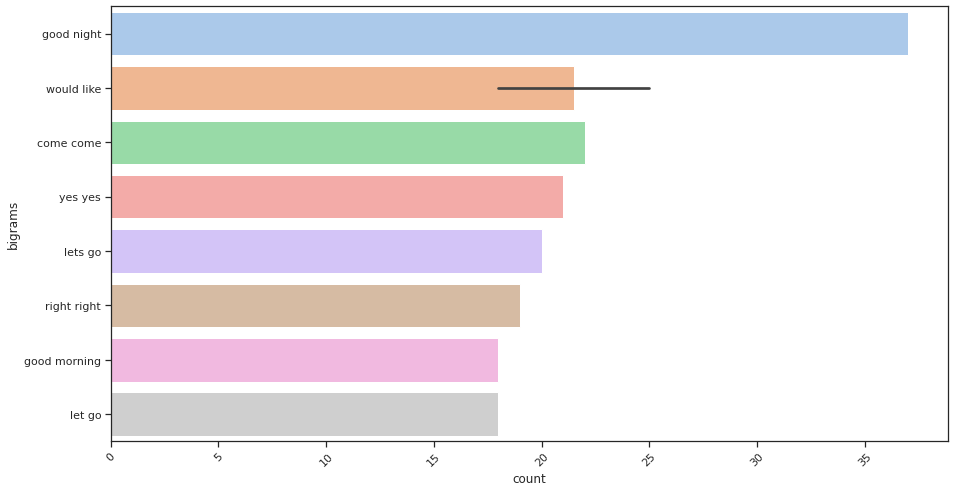

In [20]:
plt.figure(figsize=(15, 8))
sns.barplot(x='count', y='bigrams', orient='h', data=bigrams_top_10)
plt.xticks(rotation=45)
plt.savefig('top_10_bigram_author.png')
plt.show()

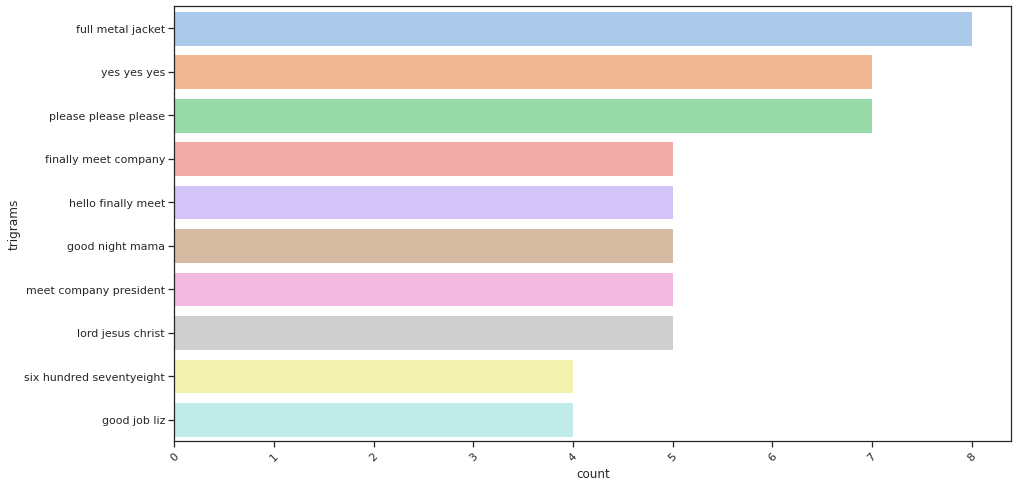

In [21]:
plt.figure(figsize=(15, 8))
sns.barplot(x='count', y='trigrams', orient='h', data=trigrams_top_10)
plt.xticks(rotation=45)
plt.savefig('top_10_trigram_author.png')
plt.show()

### 1.5. Облако слов по автору

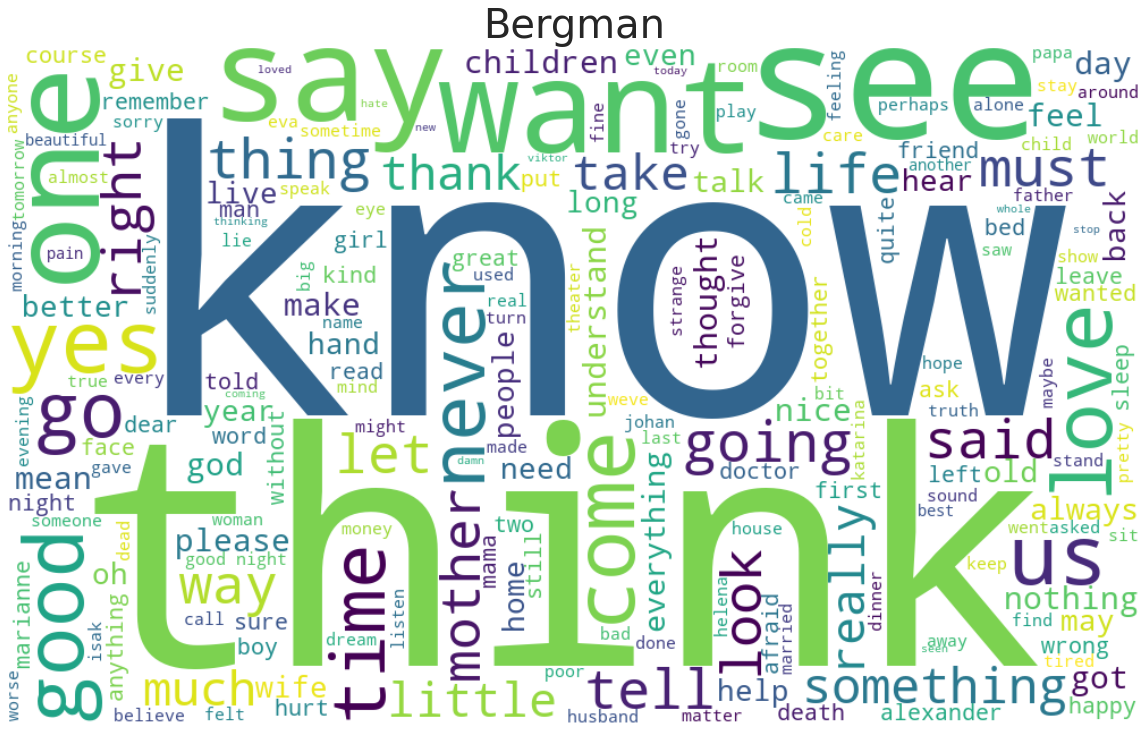

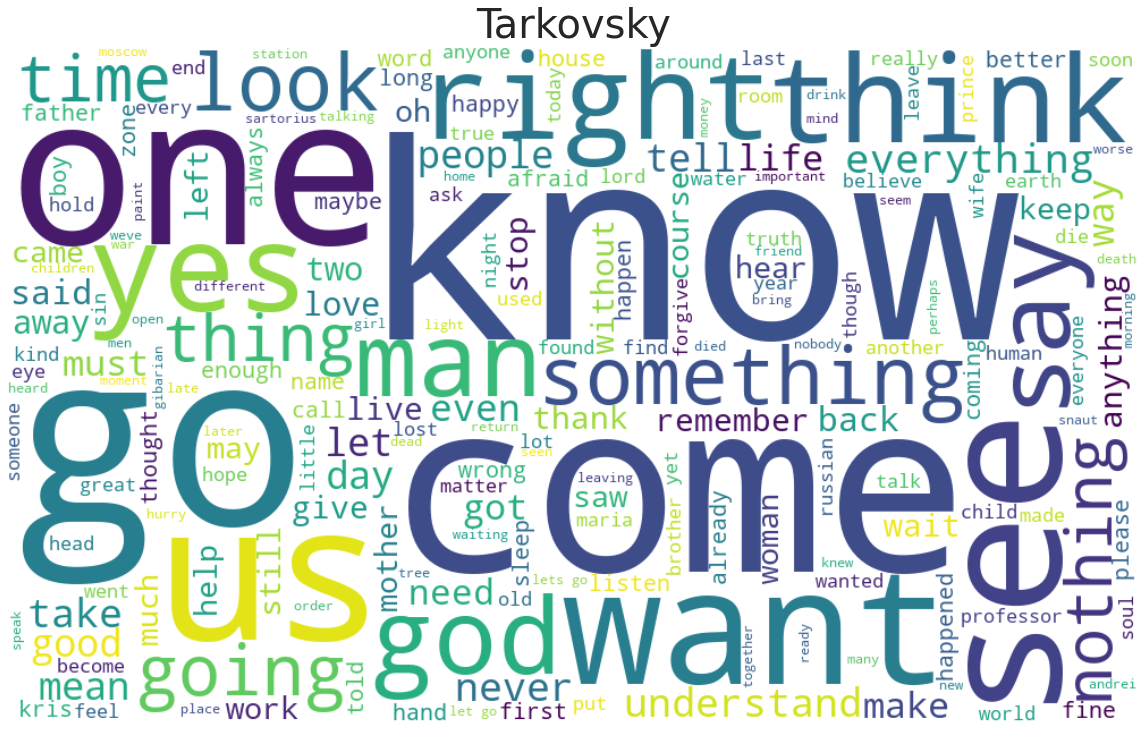

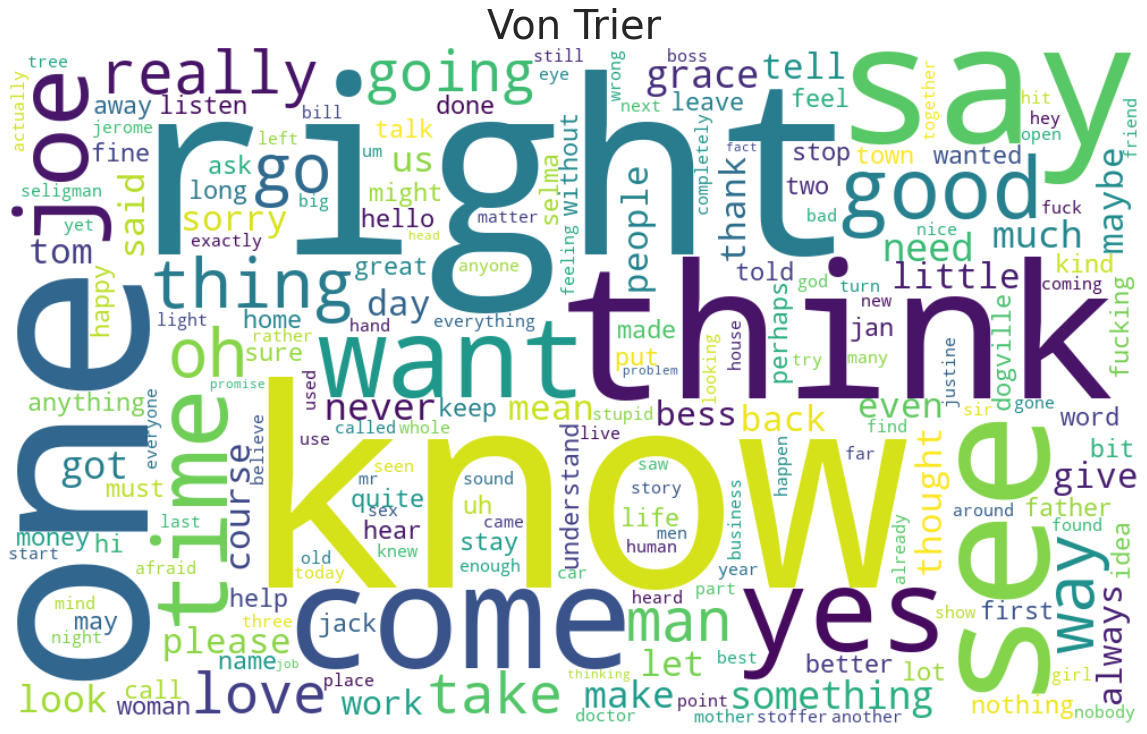

In [22]:
authors = {0: 'Bergman', 1: 'Tarkovsky', 2: 'Von Trier'}

word_clouds = []
for author in range(3):
    word_clouds.append(
        WordCloud(
            width=1000, height=600,
            background_color='white',
            collocations=True,
            min_font_size=10
        ).generate(' '.join(sentences_df[sentences_df['author'] == authors[author]]['tokens'].to_list()[0]))
    )
    
for idx, cloud in enumerate(word_clouds):
    plt.figure(figsize=(20, 10), facecolor=None)
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(authors[idx], fontdict={'fontsize': 40})
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'wordcloud_{authors[idx]}.png')
    plt.show()

### 1.6 Облако слов по всему корпусу

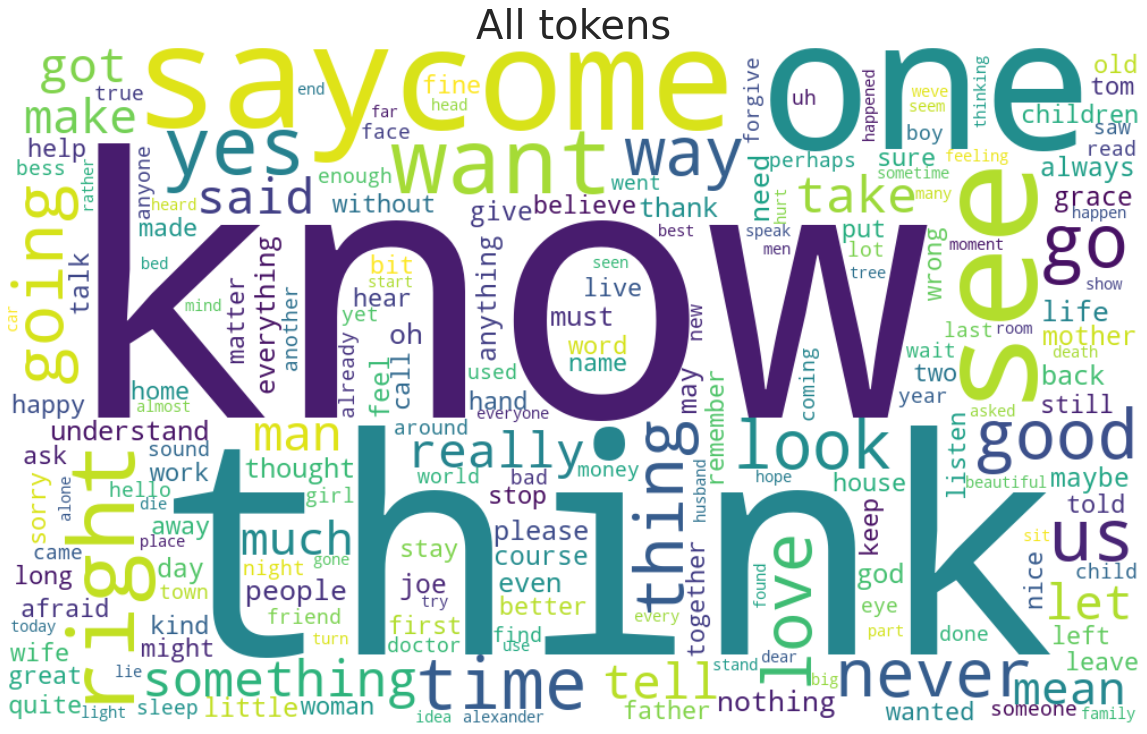

In [23]:
all_tokens = [item for sublist in sentences_df['tokens'] for item in sublist]

cloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    collocations=True,
    min_font_size=10,
).generate(' '.join(all_tokens))

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(cloud, interpolation='bilinear')
plt.title('All tokens', fontdict={'fontsize': 40})
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('wordcloud_all.png')
plt.show()

### 1.7. Распределение частей речи

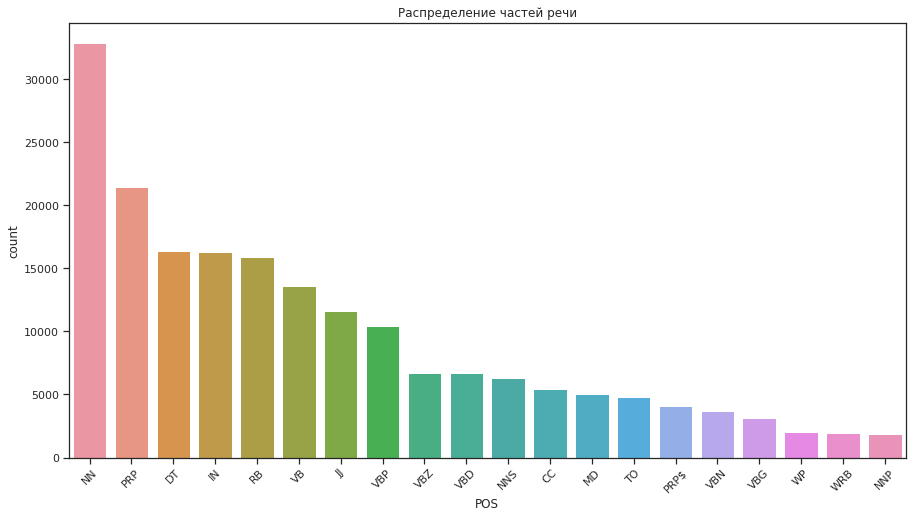

In [24]:
nltk_tagger = NLTKTagger()

blob = TextBlob(' '.join(sentences_df['text'].values), pos_tagger=nltk_tagger)
pos_df = pd.DataFrame(blob.tags, columns=['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]

plt.figure(figsize=(15, 8))
sns.barplot(x=pos_df.index, y=pos_df.values)
plt.xticks(rotation=45)
plt.xlabel('POS')
plt.ylabel('count')
plt.title('Распределение частей речи')
plt.savefig('pos_tagging.png')
plt.show()

# 2. Topic Modeling

### 2.1. BERTopic

In [42]:
def get_docs_for_model(data: pd.DataFrame, author: str) -> List[str]:
    if author == 'all':
        docs = raw_df['text'].to_list()
    else:
        docs = raw_df[raw_df['author'] == author]['text'].to_list()
        
    docs = [item for sublist in list(map(sent_tokenize, docs)) for item in sublist]
    
    return docs

#### 2.1.1. Bergman

In [43]:
bergman_docs = get_docs_for_model(raw_df, 'Bergman')

vectorizer_model = CountVectorizer(stop_words='english')
bergman_model = BERTopic(embedding_model='all-mpnet-base-v2', vectorizer_model=vectorizer_model)

topics, probs = bergman_model.fit_transform(bergman_docs)

После создания тем мы можем получить доступ к частотным темам:

In [44]:
bergman_model.get_topic_info()

Topic  Count                                    Name
0       -1   3317                    -1_like_ve_time_life
1        0    381                 0_loved_lena_woman_took
2        1    118                1_sleep_bed_asleep_tired
3        2    101                 2_come_tree_forest_join
4        3    100                3_money_owe_kronor_chest
..     ...    ...                                     ...
183    182     11          182_reason_reasons_wonder_hell
184    183     11                183_ask_asking_asked_yes
185    184     10          184_silly_ironic_suits_suggest
186    185     10  185_concerts_performing_stage_sneaking
187    186     10            186_lonely_isolated_lead_fun

[188 rows x 3 columns]

-1 относится ко всем выбросам и обычно должен игнорироваться. Взглянем на наиболее частотную тему 0:

In [45]:
bergman_model.get_topic(0)

[('loved', 0.013931211576278647),
 ('lena', 0.013612013989478866),
 ('woman', 0.010719550293302038),
 ('took', 0.009763399292808884),
 ('actually', 0.008828726096388437),
 ('sat', 0.00857987578292314),
 ('said', 0.008500103924021197),
 ('room', 0.008337428005901586),
 ('ran', 0.008069629445467557),
 ('nose', 0.008069629445467557)]

Мы можем создать обзор наиболее частых тем таким образом, чтобы их было легко интерпретировать. Горизонтальные гистограммы обычно довольно хорошо передают информацию и обеспечивают интуитивное представление тем:

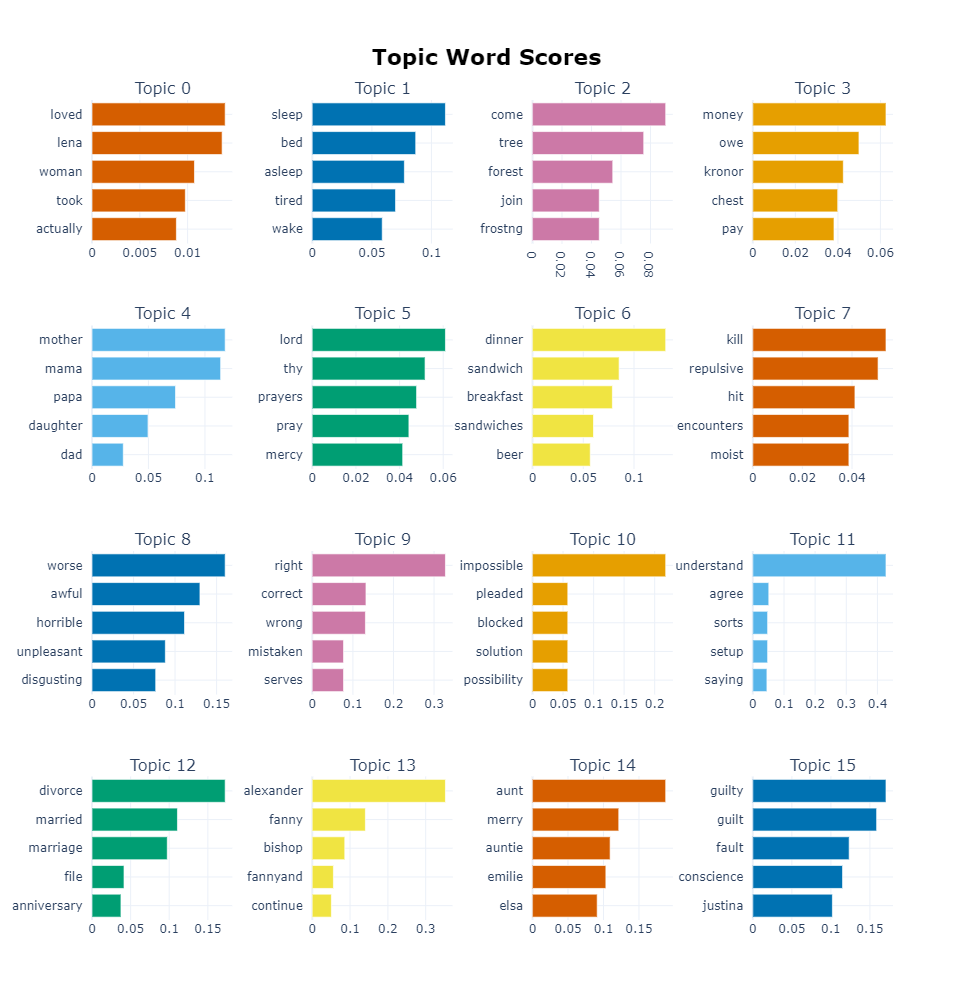

In [46]:
bergman_model.visualize_barchart(top_n_topics=16)

После обучения модели мы можем итеративно просмотреть, возможно, сотню тем, чтобы получить хорошее представление о темах, которые были извлечены. Однако это занимает довольно много времени и не имеет глобального представления. Вместо этого мы можем визуализировать сгенерированные темы.

Извлекая темы и их представления, может быть полезно проверить уникальность каждой темы. Некоторые темы могут быть очень похожими и могут быть объединены или просто интересны для дальнейшего изучения. Для этого мы начинаем с сопоставления наших тем с 2D-представлением, уменьшая векторы тем с помощью UMAP:

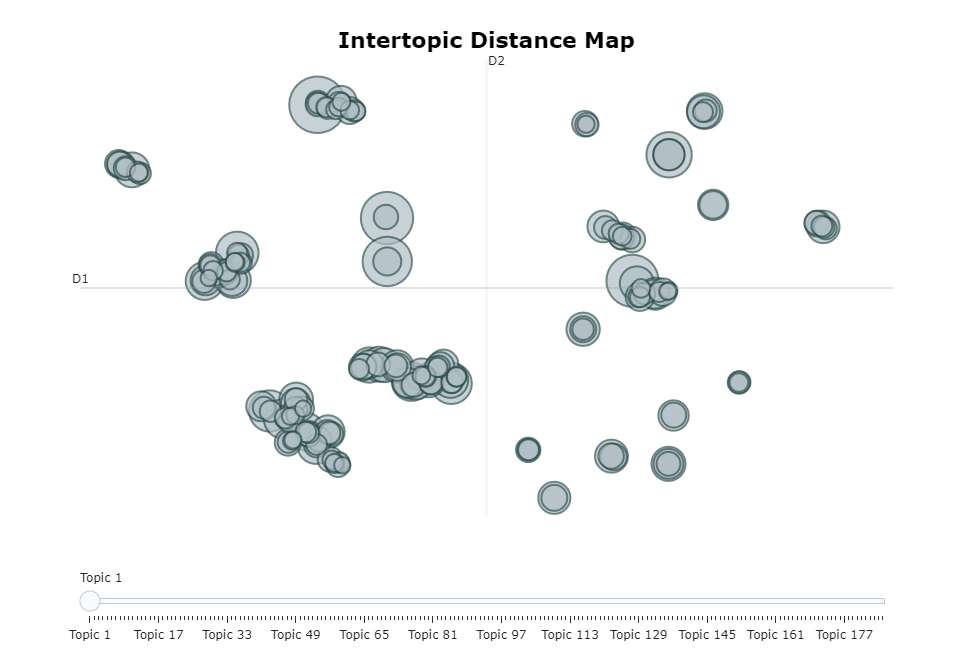

In [47]:
bergman_model.visualize_topics()

Созданные темы можно иерархически сократить. Чтобы понять потенциальную иерархическую структуру тем, мы можем использовать scipy.cluster.hierarchy для создания кластеров и визуализации того, как они связаны друг с другом. Это может помочь при выборе подходящего nr_topics при уменьшении количества тем, которые были созданы.

Расстояние между темами в определенной степени показывает сходство между темами. Однако, чтобы лучше визуализировать и понять сходство между темами, мы можем использовать два графика, чтобы лучше понять это. А именно, визуализируя возможную иерархию тем и ее матрицу подобия:

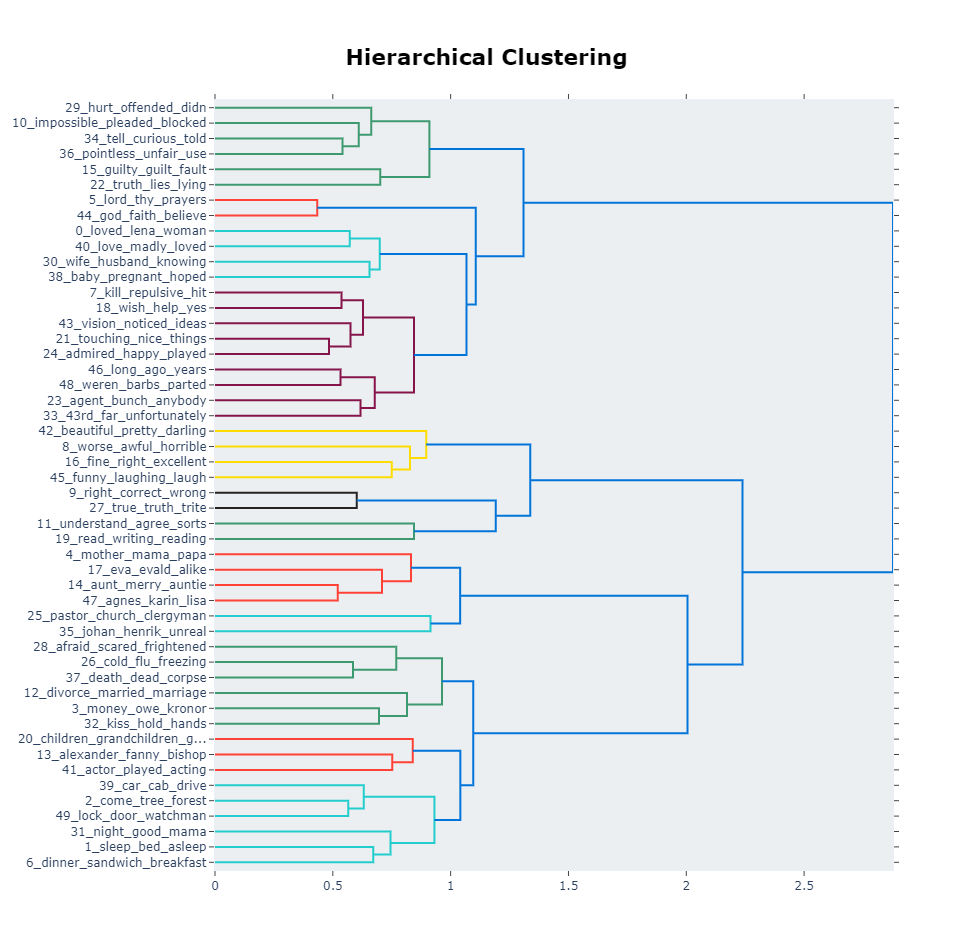

In [48]:
bergman_model.visualize_hierarchy(top_n_topics=50)

Сгенерировав темы с помощью вложений, мы можем создать матрицу подобия, просто применив косинусное сходство к этим темам. Результатом будет матрица, показывающая, насколько похожи определенные темы друг на друга.

Блочная структура тепловой карты показывает, что можно найти несколько групп тем, которые чем-то похожи друг на друга. Увеличение этих тем помогает нам понять, почему они похожи. Если вы наведете курсор на темы, вы увидите идентификатор и представление темы.

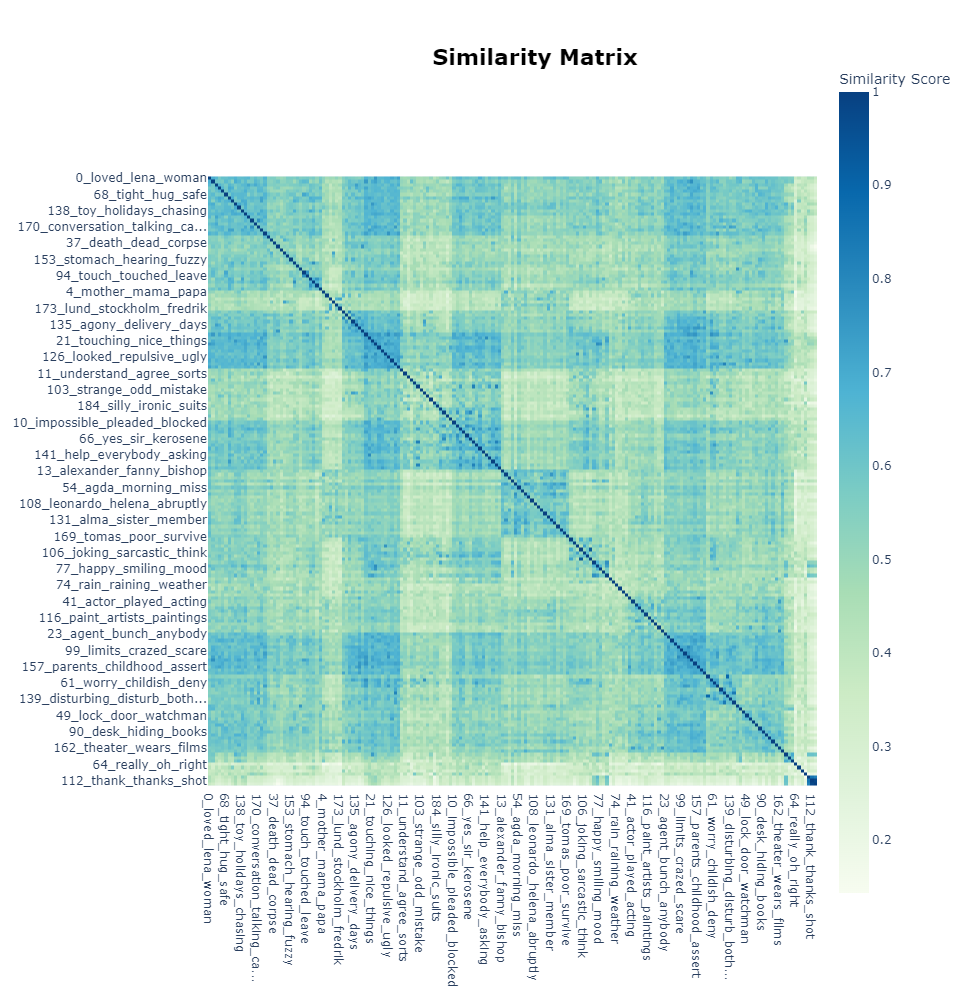

In [49]:
bergman_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.

Для каждой темы мы создали 10 слов, которые лучше всего представляют эту тему. Однако достаточно ли 10 слов? Можем ли мы уже иметь хорошее представление темы с помощью 1 слова?

Чтобы понять количество слов, необходимое для достаточного представления темы, мы можем показать снижение оценки термина при добавлении терминов. Идея заключается в том, что каждый добавленный термин имеет более низкую оценку термина, чем предыдущий, поскольку первый термин является лучшим для темы. В конце концов, мы достигаем точки убывающей отдачи, которая очень похожа на метод локтя, используемый в k-NN. Ниже вы можете увидеть снижение оценки термина при добавлении терминов в тему:

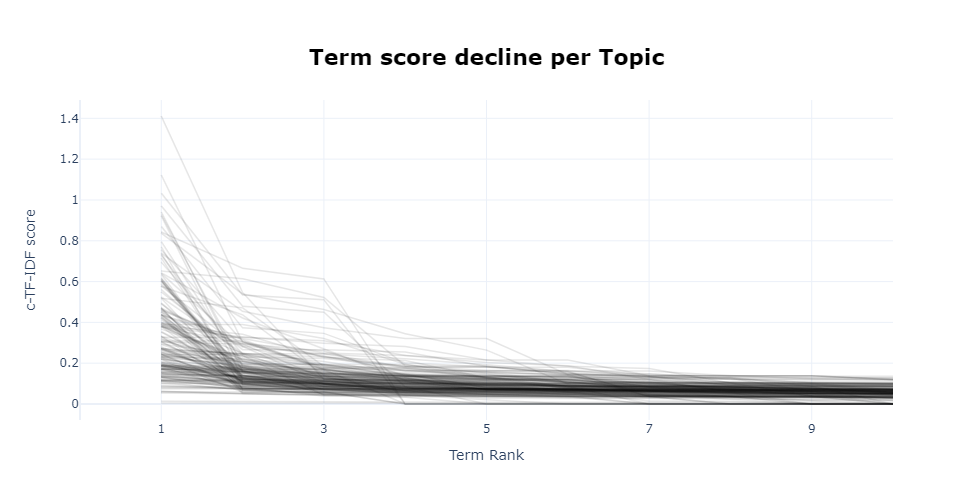

In [50]:
bergman_model.visualize_term_rank()

Мы также можем уменьшить количество тем после обучения модели BERTopic. Преимущество этого заключается в том, что вы можете определить количество тем, зная, сколько на самом деле создано. Перед обучением модели трудно предсказать, сколько тем в ваших документах и сколько будет извлечено. Вместо этого мы можем впоследствии решить, сколько тем кажется реалистичным:

In [51]:
new_topics, new_probs = bergman_model.reduce_topics(bergman_docs, topics, probs, nr_topics=80)

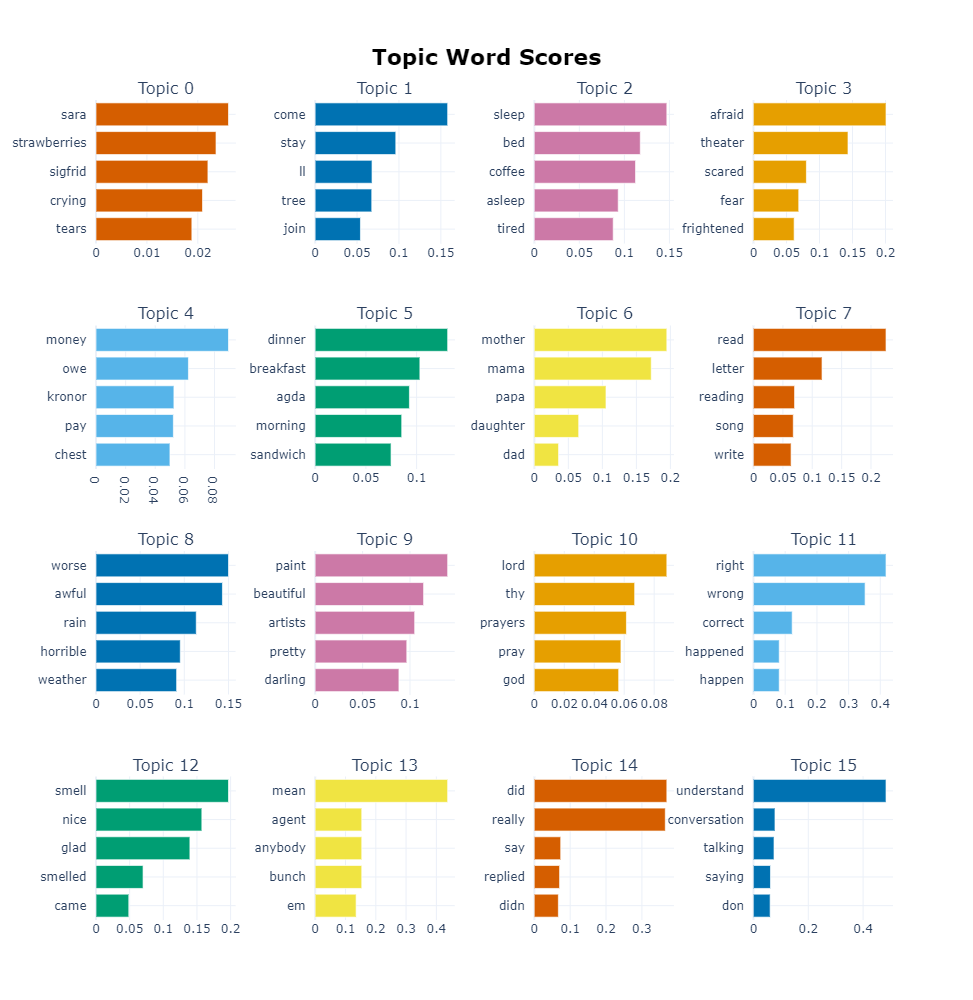

In [52]:
bergman_model.visualize_barchart(top_n_topics=16)

После обучения нашей модели мы можем использовать find_topics для поиска тем, похожих на введенный search_term. Здесь мы собираемся искать темы, которые тесно связаны с поисковым термином «сон». Затем мы извлекаем наиболее похожую тему и проверяем результаты:

In [53]:
similar_topics, similarity = bergman_model.find_topics("sleep", top_n=5)
similar_topics

[2, -1, 50, 53, 62]

#### 2.1.2. Tarkovsky

In [54]:
tarkovsky_docs = get_docs_for_model(raw_df, 'Tarkovsky')

vectorizer_model = CountVectorizer(stop_words='english')
tarkovsky_model = BERTopic(embedding_model='all-mpnet-base-v2', vectorizer_model=vectorizer_model)

topics, probs = tarkovsky_model.fit_transform(tarkovsky_docs)

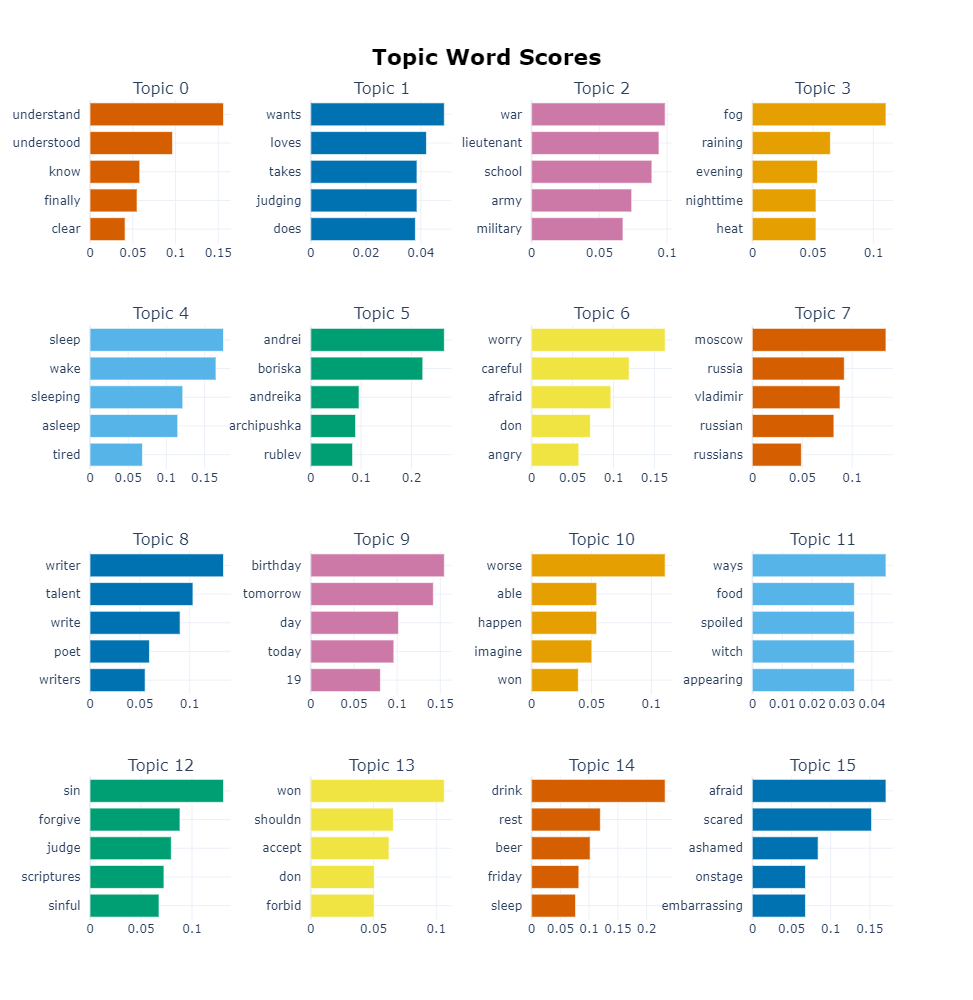

In [55]:
tarkovsky_model.visualize_barchart(top_n_topics=16)

#### 2.1.3. Von Trier

In [56]:
trier_docs = get_docs_for_model(raw_df, 'Von Trier')

vectorizer_model = CountVectorizer(stop_words='english')
trier_model = BERTopic(embedding_model='all-mpnet-base-v2', vectorizer_model=vectorizer_model)

topics, probs = trier_model.fit_transform(trier_docs)

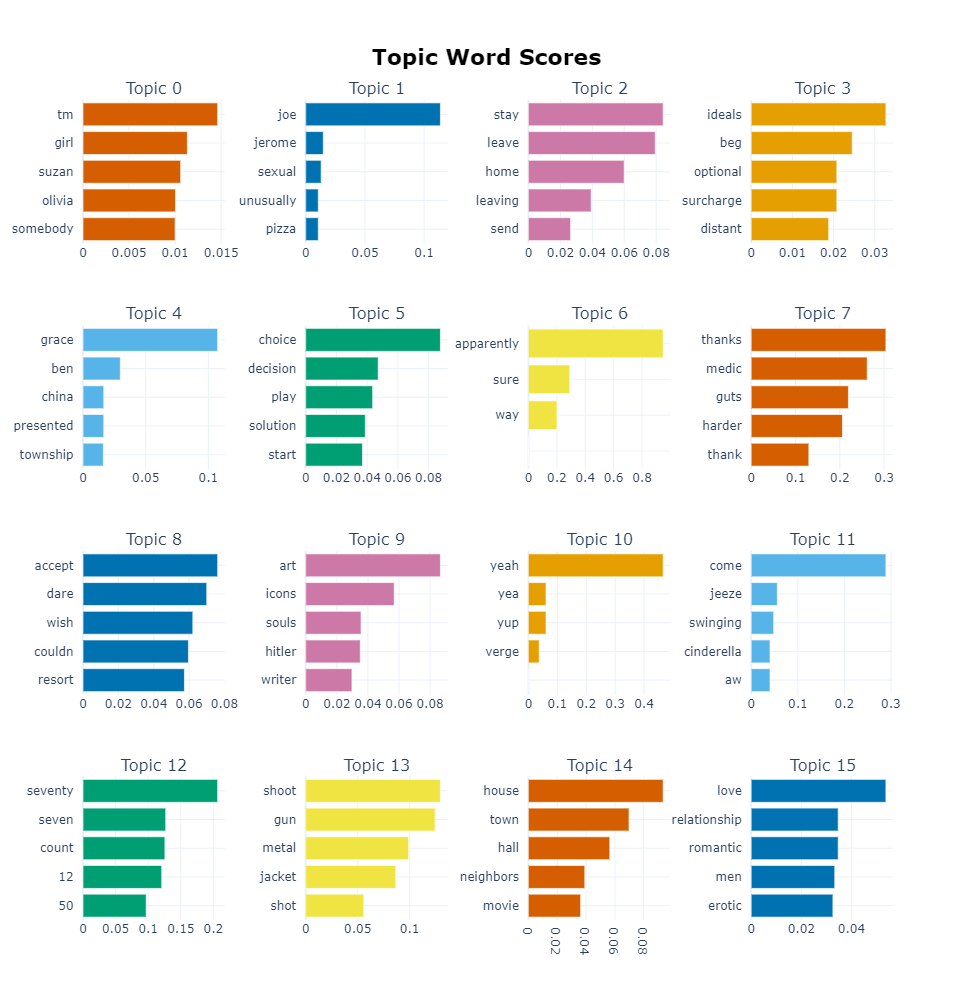

In [57]:
trier_model.visualize_barchart(top_n_topics=16)

#### 2.1.4. All

In [58]:
all_docs = get_docs_for_model(raw_df, 'all')

vectorizer_model = CountVectorizer(stop_words='english')
all_model = BERTopic(embedding_model='all-mpnet-base-v2', vectorizer_model=vectorizer_model)

topics, probs = all_model.fit_transform(all_docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

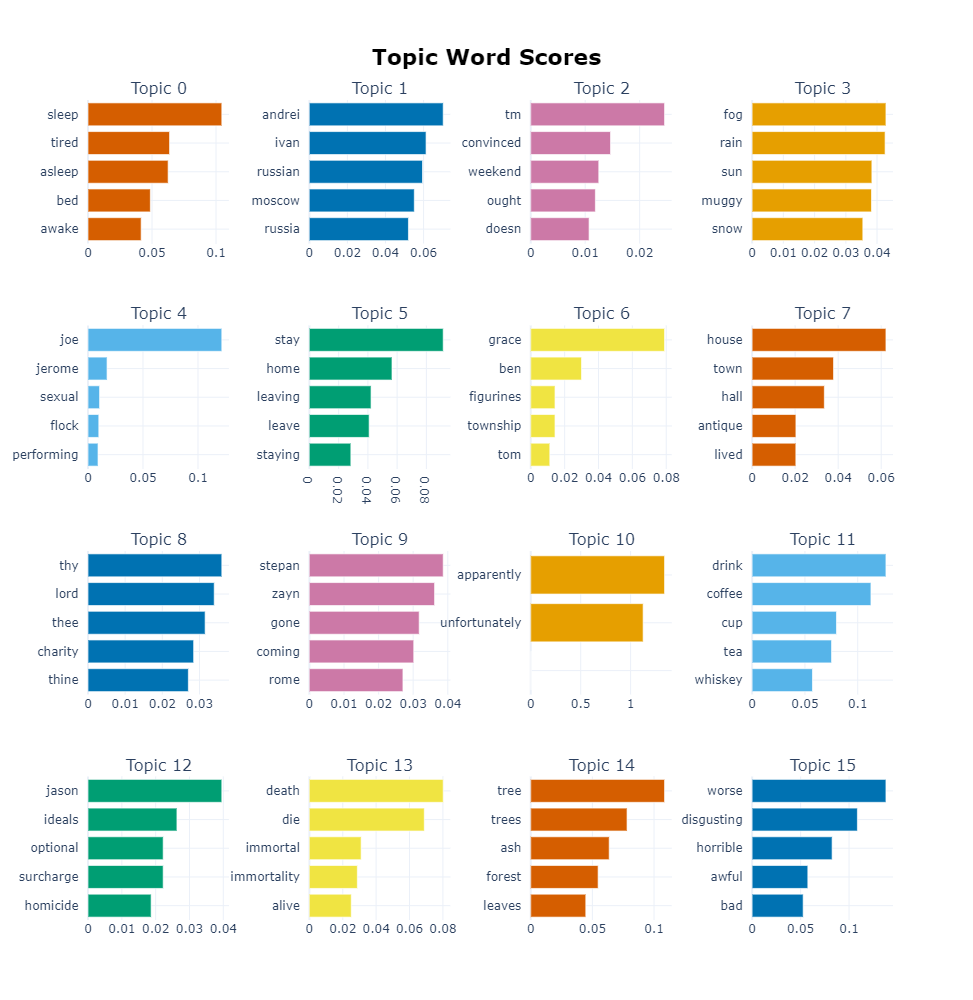

In [59]:
all_model.visualize_barchart(top_n_topics=16)